# Problem Statement
---

# Data Preparation and Exploration Data Analysis
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import initializers

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


[Agrimonia_Dataset](https://zenodo.org/record/6620530#.Y1Fkf3bP1PY)
- [Air quality index](https://airindex.eea.europa.eu/Map/AQI/Viewer/#)
- [Air quality index2](https://www.euronews.com/weather/copernicus-air-quality-index)

## Data cleaning

In [2]:
df = pd.read_csv("./data/Agrimonia_Dataset.csv",low_memory=False)

In [3]:
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,NaN,NaN,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,3.832e-01,5.892e+00,3.998,1.234,112.0,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,NaN,NaN,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,NaN,NaN,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,NaN,NaN,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,NaN,NaN,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,3.832e-01,5.892e+00,3.997,1.233,112.0,17.0


In [4]:
# Check shape of the data set
df.shape

(309072, 41)

In [5]:
# Check type of the data set
df.dtypes

IDStations                      object
Latitude                       float64
Longitude                      float64
Time                            object
Altitude                         int64
AQ_pm10                         object
AQ_pm25                         object
AQ_co                           object
AQ_nh3                          object
AQ_nox                          object
AQ_no2                          object
AQ_so2                          object
WE_temp_2m                     float64
WE_wind_speed_10m_mean         float64
WE_wind_speed_10m_max          float64
WE_mode_wind_direction_10m      object
WE_tot_precipitation           float64
WE_precipication_t               int64
WE_surface_pressure            float64
WE_solar_radiation             float64
WE_rh_min                      float64
WE_rh_mean                     float64
WE_rh_max                      float64
WE_wind_speed_100m_mean        float64
WE_wind_speed_100m_max         float64
WE_mode_wind_direction_10

In [6]:
# Check missing value in the data set
df.isnull().sum()[df.isnull().sum() != 0]

LA_land_use      6576
LA_soil_use    160738
dtype: int64

In [7]:
# Select object columns
object_col = df.select_dtypes(include='object').columns
object_col

Index(['IDStations', 'Time', 'AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox',
       'AQ_no2', 'AQ_so2', 'WE_mode_wind_direction_10m',
       'WE_mode_wind_direction_100m', 'EM_nh3_livestock_mm',
       'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum',
       'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine'],
      dtype='object')

In [8]:
# `NaN` in the air quality columns is imputed the value 
# which is noise of the data.
aq_col = ['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3',
          'AQ_nox', 'AQ_no2', 'AQ_so2']
for col in list(aq_col):
    print(f"Missing value 'NaN' in column {col}: {df[col].str.contains('NaN').sum()}")

Missing value 'NaN' in column AQ_pm10: 89634
Missing value 'NaN' in column AQ_pm25: 208379
Missing value 'NaN' in column AQ_co: 197180
Missing value 'NaN' in column AQ_nh3: 292617
Missing value 'NaN' in column AQ_nox: 107843
Missing value 'NaN' in column AQ_no2: 49132
Missing value 'NaN' in column AQ_so2: 227026


In [9]:
# Remove space of `NaN` value in dataframe
df = df.replace('\s+','',regex=True)

In [10]:
# Impute missing all `NaN` value with 0
df = df.replace('NaN',0)
df = df.fillna(0)
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,0,0,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,3.832e-01,5.892e+00,3.998,1.234,112.0,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,0,0,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,0,0,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,0,0,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,0,0,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,3.832e-01,5.892e+00,3.997,1.233,112.0,17.0


In [11]:
# Convert object column except 'IDStations', 'Time','WE_mode_wind_direction_10m' and, 
# 'WE_mode_wind_direction_100m' columns to float
to_float_col = df.select_dtypes(include='object').drop(columns=['IDStations', 'Time',
                 'WE_mode_wind_direction_10m', 
                 'WE_mode_wind_direction_100m']).columns
for col in to_float_col:
    df[col] = df[col].astype(float)
df[to_float_col].dtypes

AQ_pm10                  float64
AQ_pm25                  float64
AQ_co                    float64
AQ_nh3                   float64
AQ_nox                   float64
AQ_no2                   float64
AQ_so2                   float64
EM_nh3_livestock_mm      float64
EM_nh3_agr_soils         float64
EM_nh3_agr_waste_burn    float64
EM_nh3_sum               float64
EM_nox_traffic           float64
EM_nox_sum               float64
EM_so2_sum               float64
LI_pigs                  float64
LI_bovine                float64
dtype: object

In [12]:
# Number of row that have value of 0
(df == 0).sum()[(df == 0).sum() != 0]

AQ_pm10                   90053
AQ_pm25                  208699
AQ_co                    197297
AQ_nh3                   293053
AQ_nox                   107843
AQ_no2                    49136
AQ_so2                   227037
WE_tot_precipitation      10224
WE_precipication_t       213689
EM_nh3_livestock_mm       51465
EM_nh3_agr_soils          51465
EM_nh3_agr_waste_burn     54492
EM_nh3_sum                51465
EM_nox_traffic            51465
EM_nox_sum                51465
EM_so2_sum                51465
LI_pigs                   45714
LI_bovine                 24674
LA_land_use                6576
LA_soil_use              173478
dtype: int64

In [13]:
df['IDStations'].nunique()

141

In [14]:
df['Time'] = pd.to_datetime(df['Time'])

In [15]:
# df.describe().round(2).T[['mean','std','min','50%','max']]

In [16]:
# Convert `WE_surface_pressure` and `WE_solar_radiation` unit
# to MPa and MJ/m^2 respectively
# Divided the value in this 2 columns by 100_000
# Purpose: change the scale of the data
df['WE_surface_pressure'] = df['WE_surface_pressure']/100_000
df['WE_solar_radiation'] = df['WE_solar_radiation']/100_000

In [17]:
df_time_index = df.copy()

In [18]:
# Set time to index
df_time_index.set_index('Time',inplace=True)

In [19]:
df_time_index.head(1)

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1264,46.167852,9.87921,290,62.0,53.0,0.0,0.0,82.63,37.72,...,0.6166,0.8359,1.72,0.3906,0.3832,5.892,3.998,1.234,112.0,17.0


In [20]:
df_time_index.columns

Index(['IDStations', 'Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25',
       'AQ_co', 'AQ_nh3', 'AQ_nox', 'AQ_no2', 'AQ_so2', 'WE_temp_2m',
       'WE_wind_speed_10m_mean', 'WE_wind_speed_10m_max',
       'WE_mode_wind_direction_10m', 'WE_tot_precipitation',
       'WE_precipication_t', 'WE_surface_pressure', 'WE_solar_radiation',
       'WE_rh_min', 'WE_rh_mean', 'WE_rh_max', 'WE_wind_speed_100m_mean',
       'WE_wind_speed_100m_max', 'WE_mode_wind_direction_100m',
       'WE_blh_layer_max', 'WE_blh_layer_min', 'EM_nh3_livestock_mm',
       'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum',
       'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine',
       'LA_hvi', 'LA_lvi', 'LA_land_use', 'LA_soil_use'],
      dtype='object')

In [21]:
# Check the available value of AQ_nh3 in the dataset 
df[df['AQ_nh3'] != 0]['IDStations'].value_counts()

677     2119
626     2081
1266    1896
642     1835
573     1736
693     1671
705     1587
703     1528
681     1273
583      293
Name: IDStations, dtype: int64

## Exploration Data Analysis

In [22]:
aq_col = df.columns[df.columns.str.contains('AQ')]
aq_col

Index(['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox', 'AQ_no2', 'AQ_so2'], dtype='object')

In [23]:
overall_station_polltion = df.groupby(['IDStations']).mean()[aq_col].round(2)
overall_station_polltion.head()

,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,AQ_so2
IDStations,,,,,,,
1264,21.57,17.25,0.00,0.00,37.46,18.59,0.0
1265,30.33,23.19,0.00,0.00,53.01,28.62,0.0
1266,30.49,0.00,0.00,29.57,37.90,22.44,0.0
1269,27.94,22.85,0.48,0.00,49.31,27.57,0.0
1274,0.00,0.00,0.00,0.00,20.64,15.20,0.0


In [24]:
def top5_pollution(quality):
    return overall_station_polltion.sort_values(f'AQ_{quality}',ascending=False)\
[[f'AQ_{quality}']].head()

In [33]:
def extract_aq_df(quality, station):
    """Filter dataframe which contain the value of air quality in the given station
    -------
    Parameter: quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               station e.g. '652', 'STA.IT1509A'
    """
    df = df_time_index[df_time_index[f'AQ_{quality}'] != 0]\
    [df_time_index[df_time_index[f'AQ_{quality}'] != 0]['IDStations'] == station]
    return df

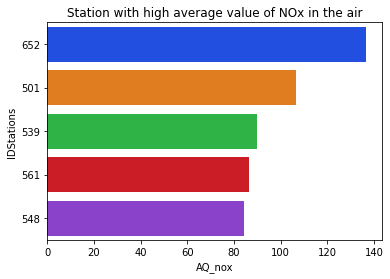

In [25]:
# 5 station that have highest overall amount of NOx in the air
sns.barplot(y=top5_pollution('nox').index, x = 'AQ_nox',data = top5_pollution('nox'))
plt.title('Station with high average value of NOx in the air');

In [138]:
extract_aq_df('nox','652')['AQ_nox'].describe()

count    2157.000000
mean      138.870283
std        82.061550
min        10.610000
25%        80.140000
50%       115.200000
75%       179.700000
max       554.400000
Name: AQ_nox, dtype: float64

In [139]:
extract_aq_df('nox','652')['AQ_nox'].skew()

1.2970630667223808

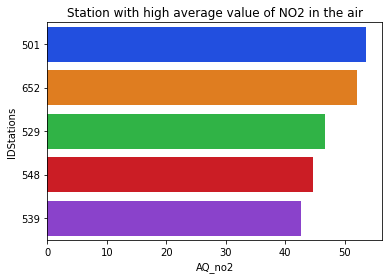

In [26]:
# 5 station that have highest overall amount of NO2 in the air
sns.barplot(y=top5_pollution('no2').index, x = 'AQ_no2',data = top5_pollution('no2'))
plt.title('Station with high average value of NO2 in the air');

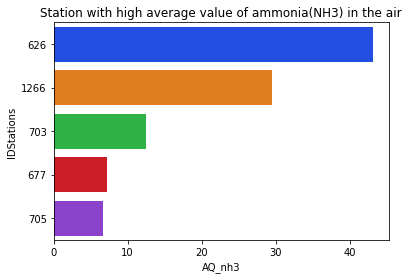

In [27]:
# 5 station that have highest overall amount of NH3 in the air
sns.barplot(y=top5_pollution('nh3').index, x = 'AQ_nh3',data = top5_pollution('nh3'))
plt.title('Station with high average value of ammonia(NH3) in the air');

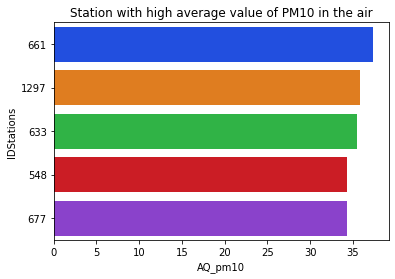

In [28]:
# 5 station that have highest overall amount of pm10 in the air
sns.barplot(y=top5_pollution('pm10').index, x = 'AQ_pm10',data = top5_pollution('pm10'))
plt.title('Station with high average value of PM10 in the air');

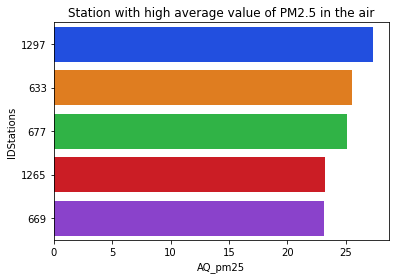

In [29]:
# 5 station that have highest overall amount of pm2.5 in the air
sns.barplot(y=top5_pollution('pm25').index, x = 'AQ_pm25',data = top5_pollution('pm25'))
plt.title('Station with high average value of PM2.5 in the air');

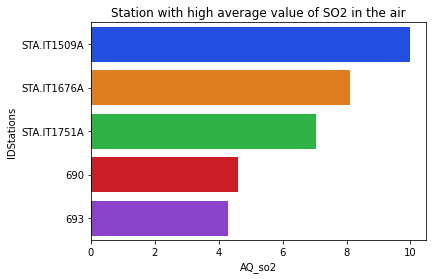

In [30]:
# 5 station that have highest overall amount of SO2 in the air
sns.barplot(y=top5_pollution('so2').index, x = 'AQ_so2',data = top5_pollution('so2'))
plt.title('Station with high average value of SO2 in the air');

In [31]:
# Most station for each air pollution
most_pollution = pd.DataFrame(columns=['IDStations', 'quality', 'Values'])
for i, quality in enumerate(['nox','no2','nh3','pm10','pm25','so2']):
    most_pol_temp = top5_pollution(quality).head(1)
    most_pollution.loc[i] = [most_pol_temp.index[0], quality, most_pol_temp.values[0][0]]

In [32]:
most_pollution

,IDStations,quality,Values
0,652,nox,136.65
1,501,no2,53.63
2,626,nh3,43.11
3,661,pm10,37.31
4,1297,pm25,27.29
5,STA.IT1509A,so2,9.98


We got the stations which have the most pollution in each air pollution quality, then we decided to select this station for modeling and predicting the air quality. In this project, we choose only 1 station for each air quality. The model we build in this project might be the model architecture for the future project.

**In summary**, we choose station for each pollutants following the analysis in the EDA section.
- Station: 652 for air quality of NO$_{x}$
- Station: 501 for air quality of NO$_{2}$
- Station: 626 for air quality of NH$_{3}$
- Station: 661 for air quality of PM$_{10}$
- Station: 1297 for air quality of PM$_{2.5}$
- Station: STA.IT1509A for air quality of SO$_{2}$

# Modeling and Model evaluation
---
In the modeling and model evaluation section, we used the ordinary time series model which is ARIMA model and advance model such as recurrent neural network model (RNN) and Long short-term memory model (LSTM). This section contains 7 parts.
1. Function using in the modeling section
2. Model for predicting nitrogen oxide (NO$_{x}$) quantity of station 652
3. Model for predicting nitrogen dioxide (NO$_{2}$) quantity of station 501
4. Model for predicting ammonia (NH$_{3}$) quantity of station 626
5. Model for predicting PM$_{10}$ of station 661
6. Model for predicting PM$_{2.5}$ of station 1297
7. Model for predicting sulfur dioxide (SO$_{2}$) quantity of station STA.IT1509A

The modeling parts will have at least 3 models which are ARIMA, RNN and LSTM model. The train and test data of ARIMA and neural network model will split in the different method.
- For ARIMA model, The test data will be the small size (~5% of the data) because ARIMA model will predict the mean of the data in the long term.
- For RNN and LSTM model, The test data will be the default size of the split in the Scikit-learn (25% of the data).

The evaluation of the model will be one or more of the below list.
- Score of the model: Mean square error, Akaike Information Critera (for ARIMA model)
- Ablity for capture the trend in the time series data observed by time series graph

## Function using in the modeling section
This part is gathering the function using in the modeling section.
1. Function using for extract/visualize the data
2. Function using in the ARIMA model

### Function using for extract/visualize the data

In [34]:
def station_daily(station, quality, label):
    """Display daily air quality of the given station
    -------
    Parameter: station e.g. '652', 'STA.IT1509A'
               quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               label: label of y axis
    """
    plt.figure(figsize=(15,6))
    df_temp = extract_aq_df(quality,station)
    plt.plot(df_temp[f'AQ_{quality}'], color='royalblue')
    plt.title(f'Daily {label} quantity of station {station}',fontsize=18)
    plt.ylabel(label, fontsize=15)
    plt.xlabel('Time', fontsize=15)
    plt.axhline(df_temp[f'AQ_{quality}'].mean(),color='salmon');

### Function using in the ARIMA model

In [35]:
def interpret_dftest(dftest):
    """Check for stationary of the time series data
    -------
    Parameter: Adfuller of extracted dataframe
    Return: Dataframe with Test statistic and p-value
    """
    dfoutput = pd.Series(dftest[0:2], 
                         index=['Test Statistic','p-value'])
    return dfoutput

In [36]:
def train_test_time_series(station, quality,test_size=0.1):
    """Split the data for statistic model e.g. ARIMA
    -------
    Parameter: station e.g. '652', 'STA.IT1509A'
               quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               test_size: float 0 to 1 with default=0.1
    Return: train, test
    """
    train, test = train_test_split(extract_aq_df(quality,station)[f'AQ_{quality}'],
                                       test_size=test_size,
                                       shuffle=False)
    # Assign frequency of data
    train.index = train.index.to_period('d')
    test.index = test.index.to_period('d')
    return train, test

In [37]:
def fit_preds(stat_model, test, show_aic=True, show_mse=True):
    """Fit and Predict value from statistic model e.g. ARIMA
    -------
    Parameter:  stat_model: Instantiate statistic model
                test: test set data 
                show_aic: bool print Akaike Information Critera with default = True
                show_mse: bool print Mean Square Error with default = True
    Return: preds, model.aic, mean_squared_error(test, preds)
    """
    model = stat_model.fit()
    # preds = model.predict(start=train.shape[0], end=(train.shape[0]+test.shape[0]-1))
    preds = model.predict(start=test.index[0], end=test.index[-1])
    if show_aic:
        print(f'AIC: {model.aic}')
    if show_mse:
        print(f'MSE: {mean_squared_error(test, preds)}')
    return preds, model.aic, mean_squared_error(test, preds)

In [38]:
def station_arima_graph(train, test, preds, quality_title, station):
    """Compare train, test and prediction from ARIMA model
    -------
    Parameter: train: train set
               test: test set
               preds: prediction set
               quality_title: title showing in the title
               station e.g. '652', 'STA.IT1509A'
    """
    plt.figure(figsize=(15,6))

    # Plot training data in blue.
    #plt.plot(train, color = 'royalblue')
    sns.lineplot(x=train.index.to_timestamp(), y=train, color = 'royalblue',label='train')

    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange',label='test')

    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green',label='predict')

    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend()
    plt.show();

In [39]:
def test_pred_graph(test, preds, quality_title, station):
    """Compare test and prediction from ARIMA model
    -------
    Parameter: test: test set
               preds: prediction set
               quality_title: title showing in the title
               station e.g. '652', 'STA.IT1509A'
    """
    plt.figure(figsize=(10,6))
    
    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange', label='test')
    
    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green', label='predict')
    
    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.legend()
    plt.show();

## Model for predicting nitrogen oxide (NO$_{x}$) quantity of station 652

### ARIMA model

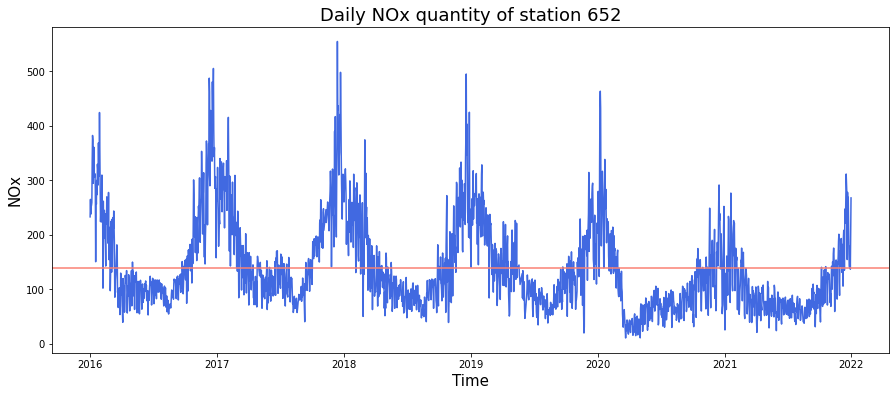

In [40]:
# NOx quantity of station 652
station_daily(station ='652',
              quality='nox',
              label='NOx')

Autocorrelation additional information: 
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/m
- https://www.influxdata.com/blog/autocorrelation-in-time-series-data/

Parial Autocorrelation additional information:
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

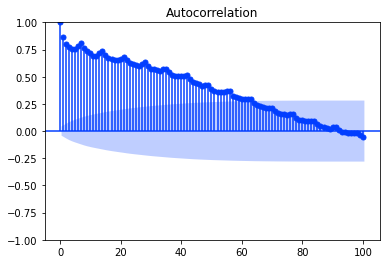

In [41]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=100);

(0.0, 20.0)

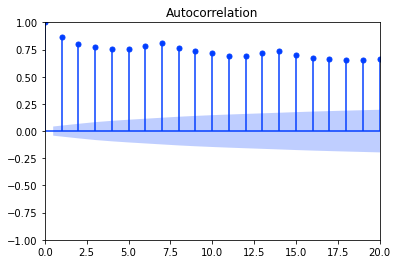

In [42]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=400);
plt.xlim(0,20)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


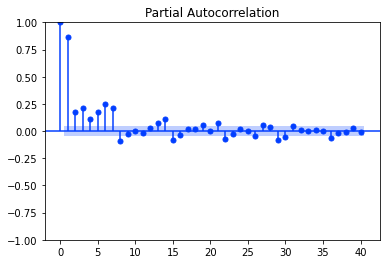

In [43]:
# Check seasonality by using acf and pacf
plot_pacf(extract_aq_df('nox','652')['AQ_nox'],lags=40);

In [44]:
# adfuller for checking the trend of station's 652 data
interpret_dftest(adfuller(extract_aq_df('nox','652')['AQ_nox'].dropna()))
# No trend

Test Statistic   -3.447531
p-value           0.009441
dtype: float64

In [157]:
train, test = train_test_time_series('652', 'nox',test_size=0.05) 

In [158]:
type(train)

pandas.core.series.Series

In [159]:
train.shape, test.shape

((2049,), (108,))

In [160]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(10,0,10))
preds, aic, mse = fit_preds(ar1, test)

AIC: 20426.190557941904
MSE: 3249.735923551522


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


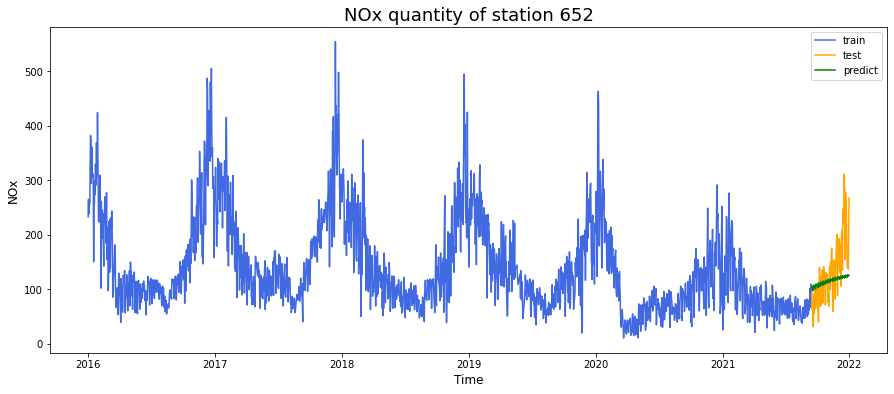

In [161]:
station_arima_graph(train, test, preds,'NOx','652')

In [162]:
# Manual Gridsearch
# p_list = [p for p in range(6,10)]
# d_list = [0, 1]
# q_list = [q for q in range(6,10)]
# manual_grid = pd.DataFrame(columns=['p','d','q','aic','mse'])
# count = 0
# for p in p_list:
#     for d in d_list:
#         for q in q_list:
#             ar1 = ARIMA(endog=train, order=(p,d,q))
#             preds, aic, mse = fit_preds(ar1, test,show_mse=False,show_aic=False)
#             manual_grid.loc[count] = [p, d, q, aic, mse]
#             count += 1
# manual_grid.to_csv('./saved_data/nox_arima_gridsearch.csv',index=False)

In [163]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/nox_arima_gridsearch.csv')

In [164]:
manual_grid.sort_values('mse').head()

,p,d,q,aic,mse
18,8.0,0.0,8.0,20421.192271,3131.433324
26,9.0,0.0,8.0,20425.767966,3134.724902
27,9.0,0.0,9.0,20422.122378,3316.109884
0,6.0,0.0,6.0,20470.080954,3351.673203
9,7.0,0.0,7.0,20456.101769,3450.973592


In [165]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(8,0,8))
preds, aic, mse = fit_preds(ar1, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC: 20421.192271111875
MSE: 3131.433323838929


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


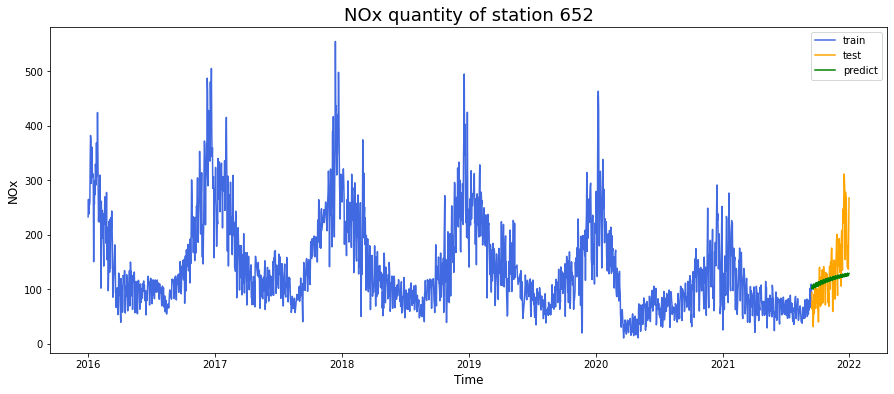

In [166]:
station_arima_graph(train, test, preds,'NOx','652')

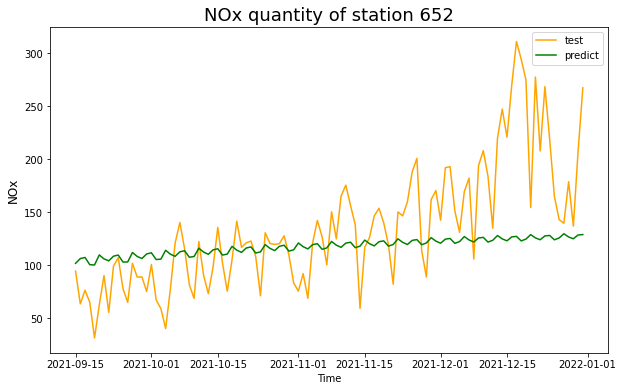

In [167]:
test_pred_graph(test,preds,'NOx','652')

### RNN model

In [168]:
# RNN model
data = extract_aq_df('nox','652')
data.head()

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,652,45.539529,10.231786,154,0.0,0.0,1.025,0.0,232.7,54.58,...,7.517,6.432,62.04,38.47,0.3875,16.41,1.937,2.165,112.0,17.0
2016-01-02,652,45.539529,10.231786,154,0.0,0.0,1.275,0.0,264.8,54.05,...,7.539,6.423,62.07,38.50,0.3875,16.39,1.937,2.165,112.0,17.0
2016-01-03,652,45.539529,10.231786,154,0.0,0.0,1.317,0.0,237.7,50.54,...,7.563,6.412,62.12,38.53,0.3875,16.38,1.937,2.164,112.0,17.0
2016-01-04,652,45.539529,10.231786,154,0.0,0.0,1.096,0.0,251.2,60.62,...,7.587,6.401,62.19,38.57,0.3875,16.38,1.936,2.164,112.0,17.0
2016-01-05,652,45.539529,10.231786,154,0.0,0.0,1.179,0.0,254.2,52.53,...,7.612,6.388,62.26,38.60,0.3875,16.37,1.936,2.164,112.0,17.0


In [169]:
X = data.select_dtypes(exclude = 'object').drop(columns=['Latitude', 'Longitude', 'Altitude',
                                                     'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',
                                                     'AQ_nox','AQ_no2','AQ_so2'])
y = data['AQ_nox']

In [170]:
y.shape[0]

2157

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [172]:
X_train.tail()

,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_tot_precipitation,WE_precipication_t,WE_surface_pressure,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2020-07-01,23.29,0.7442,1.539,0.033020,0,0.9722,170.4,89.98,94.31,99.24,...,14.71,3.566,28.69,11.20,0.6642,14.59,3.010,3.189,112.0,0.0
2020-07-02,23.34,1.0340,1.703,0.024070,0,0.9710,205.1,85.68,93.50,99.60,...,14.68,3.545,28.66,11.20,0.6642,14.59,3.014,3.193,112.0,0.0
2020-07-03,20.66,1.0620,2.013,0.180700,1,0.9734,153.2,90.45,95.15,98.56,...,14.64,3.519,28.61,11.19,0.6642,14.59,3.018,3.197,112.0,0.0
2020-07-04,21.49,0.8490,1.461,0.017120,0,0.9774,191.0,85.87,91.90,97.48,...,14.59,3.491,28.55,11.18,0.6642,14.59,3.022,3.201,112.0,0.0
2020-07-05,22.40,1.0350,1.475,0.000309,0,0.9766,204.0,87.03,92.68,98.44,...,14.53,3.459,28.46,11.17,0.6642,14.59,3.026,3.205,112.0,0.0


In [173]:
X_test.head()

,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_tot_precipitation,WE_precipication_t,WE_surface_pressure,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2020-07-06,23.69,1.0790,1.872,0.000311,0,0.9705,210.1,85.02,92.49,99.14,...,14.47,3.424,28.37,11.15,0.6642,14.59,3.030,3.209,112.0,0.0
2020-07-07,20.23,1.8670,3.085,0.011750,0,0.9757,181.5,84.23,89.81,95.04,...,14.39,3.387,28.25,11.13,0.6642,14.59,3.035,3.213,112.0,0.0
2020-07-08,20.76,0.7866,1.422,0.000732,0,0.9775,188.2,85.34,88.89,95.93,...,14.31,3.347,28.13,11.10,0.6642,14.59,3.039,3.217,112.0,0.0
2020-07-09,22.16,0.9960,1.526,0.000039,0,0.9771,208.9,84.68,90.76,97.35,...,14.23,3.306,27.99,11.07,0.6642,14.59,3.043,3.221,112.0,0.0
2020-07-10,23.55,1.1870,1.949,0.000283,0,0.9749,221.3,83.65,90.87,97.72,...,14.14,3.262,27.85,11.04,0.6642,14.59,3.047,3.225,112.0,0.0


In [174]:
# Scale
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [175]:
# This class takes in a sequence of data-points gathered at
# equal intervals, along with time series parameters such as
# stride, length of history, etc.
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                    length=3, batch_size=64)


In [176]:
train_sequences[0][0][0].shape

(3, 27)

In [177]:
input_shape = train_sequences[0][0][0].shape

In [223]:
# Design RNN
es = EarlyStopping(patience=3)
# 1. structure/topology
model = Sequential()
model.add(GRU(64, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='elu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2. Compile
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

# 3. Fit
history = model.fit(train_sequences, validation_data=test_sequences,
                    epochs=100, callbacks=[es])

Epoch 1/100
26/26 [==============================] - 4s 30ms/step - loss: 30293.2383 - val_loss: 12857.4014
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 29979.2070 - val_loss: 12732.7129
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 29403.4453 - val_loss: 12495.2100
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 28350.8965 - val_loss: 12000.7939
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 26973.3828 - val_loss: 11121.0146
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 25228.9844 - val_loss: 9841.1738
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 23204.7188 - val_loss: 8406.5693
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 20707.0078 - val_loss: 6857.7803
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 18076.0586 - val_loss: 5244.8140
Epoch 10/100
26/26 [====================

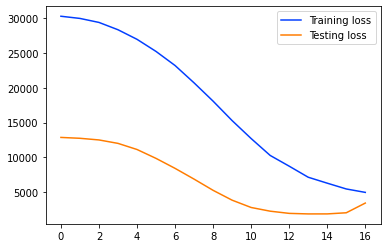

In [224]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Testing loss')
plt.legend();

In [225]:
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


In [226]:
X_test.index

DatetimeIndex(['2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09',
               '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13',
               '2020-07-14', '2020-07-15',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Time', length=540, freq=None)

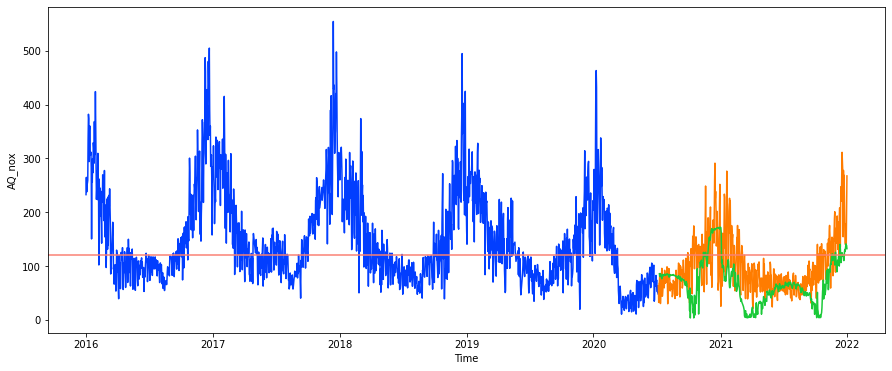

In [227]:
plt.figure(figsize=(15,6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_test.index, y=y_test)
sns.lineplot(x=X_test.index[3:], y=y_preds[:,0])
plt.axhline(120,color='red');

In [228]:
y_preds.shape, y_test.shape

((537, 1), (540,))

In [229]:
# Check amount of days that have nox in air quality > 120
performance = pd.DataFrame(y_test.iloc[3:])
performance['pred'] = y_preds
poor_nox = performance[performance['AQ_nox'] > 120].copy()
poor_nox['pred_poor'] = (poor_nox['pred'] > 120).astype(int)
poor_nox.head()

,AQ_nox,pred,pred_poor
Time,,,
2020-09-29,124.9,40.549072,0
2020-10-08,132.2,39.633354,0
2020-10-13,155.4,27.758907,0
2020-10-14,121.8,12.854522,0
2020-10-15,146.2,20.563227,0


In [230]:
print(f"Predict NOx > 120: {round(poor_nox['pred_poor'].sum()/poor_nox.shape[0]*100,2)}%")

Predict NOx > 120: 30.72%


### LSTM model
- [LSTM Example](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- **ELU activation** is very similiar to RELU except negative inputs. They are both in identity function form for non-negative inputs. On the other hand, ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes. [[Ref.]](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#:~:text=ELU%20is%20very%20similiar%20to,%CE%B1%20whereas%20RELU%20sharply%20smoothes.&text=Pros-,ELU%20becomes%20smooth%20slowly%20until%20its%20output%20equal,%CE%B1%20whereas%20RELU%20sharply%20smoothes.)

In [236]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2. Compile
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

# 3. Fit
history = model.fit(train_sequences, validation_data=test_sequences,
                    epochs=100, callbacks=[es])

Epoch 1/100
26/26 [==============================] - 4s 29ms/step - loss: 30317.0586 - val_loss: 12892.5137
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 30209.2266 - val_loss: 12793.6240
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 29976.8223 - val_loss: 12589.0654
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 29460.3906 - val_loss: 12156.1025
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 28463.5469 - val_loss: 11269.7695
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 26546.5039 - val_loss: 9793.1611
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 23124.3496 - val_loss: 7272.3794
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 17595.4590 - val_loss: 4065.0918
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 10990.6953 - val_loss: 1749.1193
Epoch 10/100
26/26 [====================

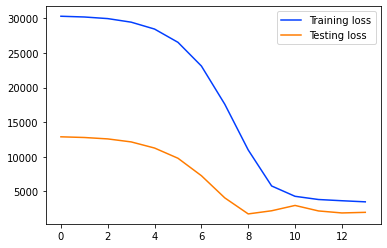

In [237]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Testing loss')
plt.legend();

In [238]:
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


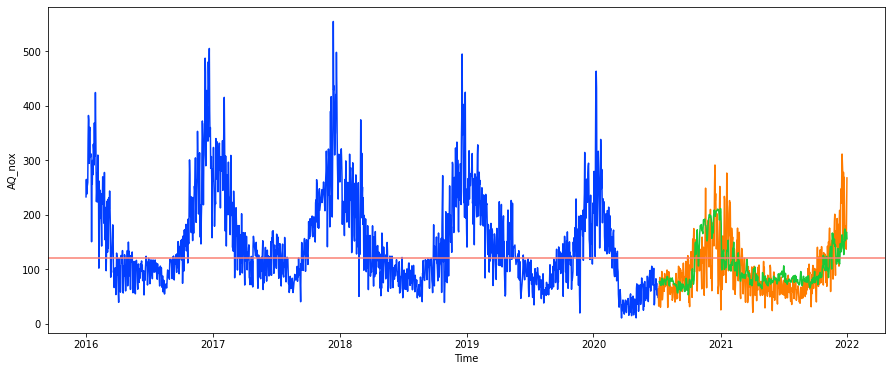

In [243]:
plt.figure(figsize=(15,6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_test.index, y=y_test)
sns.lineplot(x=X_test.index[3:], y=y_preds[:,0])
plt.axhline(120,color='red');

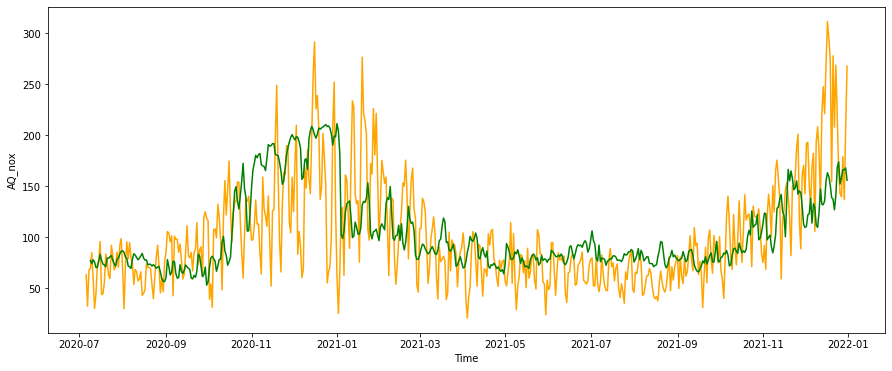

In [240]:
plt.figure(figsize=(15,6))
sns.lineplot(x=X_test.index, y=y_test,color='orange')
sns.lineplot(x=X_test.index[3:], y=y_preds[:,0],color='green');

In [241]:
# Check amount of days that have nox in air quality > 120
performance = pd.DataFrame(y_test.iloc[3:])
performance['pred'] = y_preds
poor_nox = performance[performance['AQ_nox'] > 120].copy()
poor_nox['pred_poor'] = (poor_nox['pred'] > 120).astype(int)
poor_nox.head()

,AQ_nox,pred,pred_poor
Time,,,
2020-09-29,124.9,70.796616,0
2020-10-08,132.2,71.815933,0
2020-10-13,155.4,86.314079,0
2020-10-14,121.8,82.097527,0
2020-10-15,146.2,72.557198,0


In [242]:
print(f"Predict NOx > 120: {round(poor_nox['pred_poor'].sum()/poor_nox.shape[0]*100,2)}%")

Predict NOx > 120: 59.48%


### Summary model for air quality: NO$_{x}$
The days have NO$_{x}$ quantity > 120 (Poor air quality):
- RNN model can predict NO$_{x}$ > 120 equal to 30.72%.
- LSTM model can predict NO$_{x}$ > 120 equal to 59.48%.
- LSTM performed much better than RNN model.

## Model for predicting nitrogen dioxide (NO$_{2}$) quantity of station 501

### ARIMA model

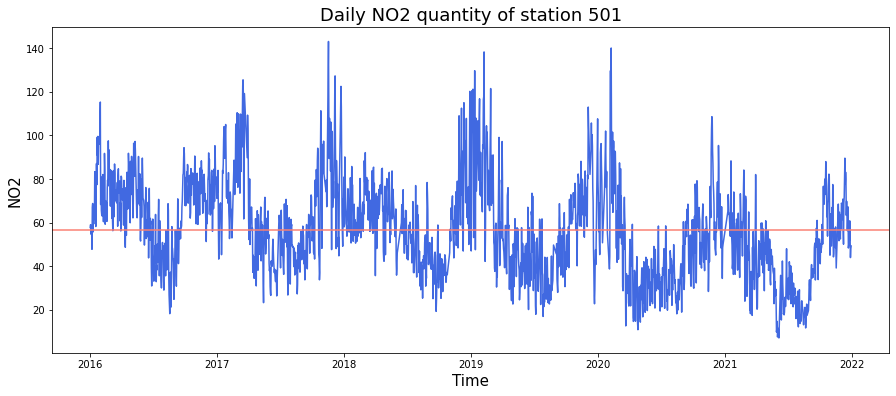

In [80]:
station_daily(station ='501',
              quality='no2',
              label='NO2')

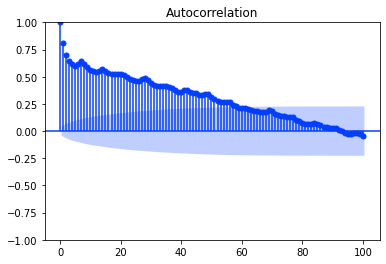

In [81]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('no2','501')['AQ_no2'],lags=100);

(0.0, 20.0)

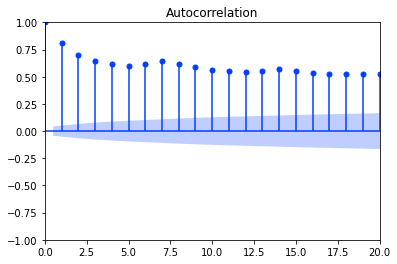

In [82]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('no2','501')['AQ_no2'],lags=400);
plt.xlim(0,20)

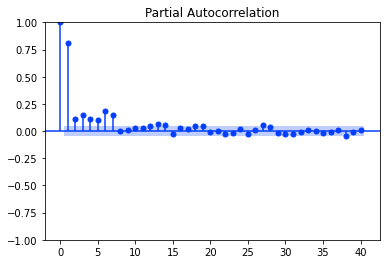

In [83]:
# Check seasonality by using acf and pacf
plot_pacf(extract_aq_df('no2','501')['AQ_no2'],lags=40,method='ywm');

In [84]:
# adfuller for checking the trend of station's 501 data
interpret_dftest(adfuller(extract_aq_df('no2','501')['AQ_no2'].dropna()))
# No trend

Test Statistic   -3.685998
p-value           0.004314
dtype: float64

In [85]:
train, test = train_test_time_series('501', 'no2',test_size=0.05)
train.shape, test.shape

((1965,), (104,))

In [86]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [87]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 15611.48998215408
MSE: 171.9746066755182


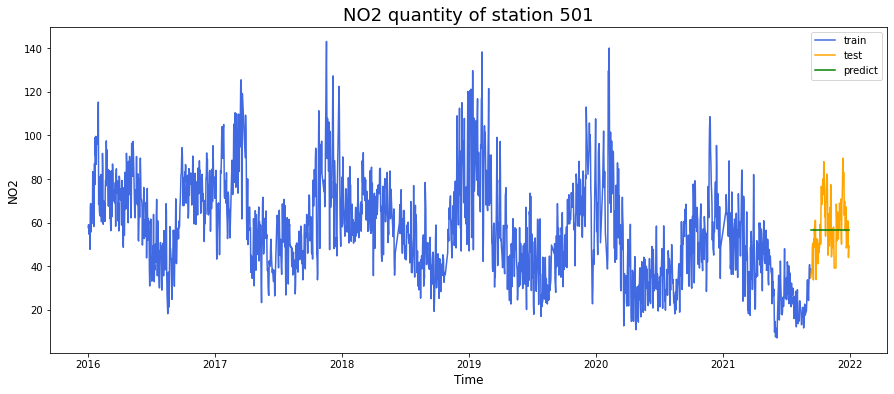

In [88]:
station_arima_graph(train, test, preds, 'NO2', '501')

In [97]:
# Manual Gridsearch
# p_list = [p for p in range(6,10)]
# d_list = [0, 1]
# q_list = [q for q in range(6,10)]
# manual_grid = pd.DataFrame(columns=['p','d','q','aic','mse'])
# count = 0
# for p in p_list:
#     for d in d_list:
#         for q in q_list:
#             ar1 = ARIMA(endog=train, order=(p,d,q))
#             preds, aic, mse = fit_preds(ar1, test,show_mse=False,show_aic=False)
#             manual_grid.loc[count] = [p, d, q, aic, mse]
#             count += 1
# manual_grid.to_csv('./saved_data/no2_arima_gridsearch.csv',index=False)

In [90]:
manual_grid = pd.read_csv('./saved_data/no2_arima_gridsearch.csv')

In [99]:
manual_grid.sort_values('mse').head()

,p,d,q,aic,mse
16,8.0,0.0,6.0,15382.837409,171.968557
24,9.0,0.0,6.0,15387.214844,173.317828
0,6.0,0.0,6.0,15384.586456,173.698826
27,9.0,0.0,9.0,15373.899422,174.402237
1,6.0,0.0,7.0,15383.276898,175.619961


In [100]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(8,0,6))
preds, aic, mse = fit_preds(ar1, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC: 15382.837408521322
MSE: 171.96855673365775


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


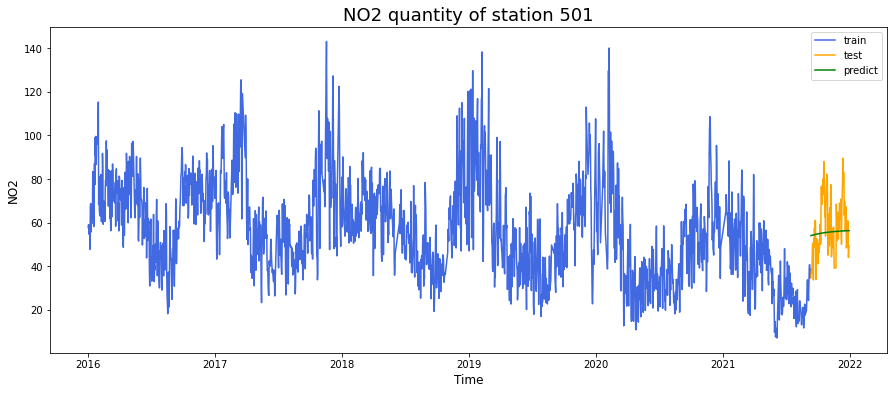

In [101]:
station_arima_graph(train, test, preds, 'NO2', '501')

ARIMA model can't capture trend of the series.

### RNN model

In [293]:
data = extract_aq_df('no2','501')
data.head()

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,501,45.496316,9.190934,129,0.0,0.0,2.217,0.0,152.9,57.76,...,11.52,13.40,110.7,16.66,0.2587,3.666,2.184,1.362,112.0,17.0
2016-01-02,501,45.496316,9.190934,129,0.0,0.0,2.163,0.0,132.6,59.06,...,11.54,13.37,110.9,16.70,0.2587,3.666,2.183,1.361,112.0,17.0
2016-01-03,501,45.496316,9.190934,129,0.0,0.0,2.154,0.0,103.3,55.02,...,11.57,13.35,111.0,16.75,0.2587,3.666,2.183,1.360,112.0,17.0
2016-01-04,501,45.496316,9.190934,129,0.0,0.0,2.163,0.0,112.0,54.58,...,11.60,13.32,111.1,16.81,0.2587,3.666,2.183,1.359,112.0,17.0
2016-01-05,501,45.496316,9.190934,129,0.0,0.0,2.237,0.0,136.9,56.60,...,11.63,13.28,111.3,16.86,0.2587,3.666,2.183,1.358,112.0,17.0


In [294]:
X = data.select_dtypes(exclude = 'object').drop(columns=['Latitude', 'Longitude', 'Altitude',
                                                     'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',
                                                     'AQ_nox','AQ_no2','AQ_so2'])
y = data['AQ_no2']

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [296]:
# Scale
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [297]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                    length=3, batch_size=64)
input_shape = train_sequences[0][0][0].shape

In [298]:
# Design RNN
es = EarlyStopping(patience=3)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, input_shape=input_shape, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))


# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2. Compile
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

# 3. Fit
history = model.fit(train_sequences, validation_data=test_sequences,
                    epochs=100, callbacks=[es])

# 4. Predict
y_preds = model.predict(test_sequences)

Epoch 1/100
25/25 [==============================] - 3s 26ms/step - loss: 4106.2734 - val_loss: 2400.9165
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 4058.2048 - val_loss: 2364.1050
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 3991.8386 - val_loss: 2310.1089
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 3879.0659 - val_loss: 2232.5125
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 3676.3640 - val_loss: 2098.6758
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 3322.8030 - val_loss: 1859.8910
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 2794.7659 - val_loss: 1498.0482
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 2143.2998 - val_loss: 1032.9452
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 1419.8549 - val_loss: 467.5948
Epoch 10/100
25/25 [==============================] - 0

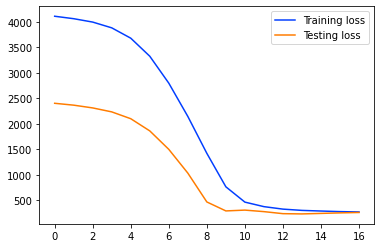

In [299]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Testing loss')
plt.legend();

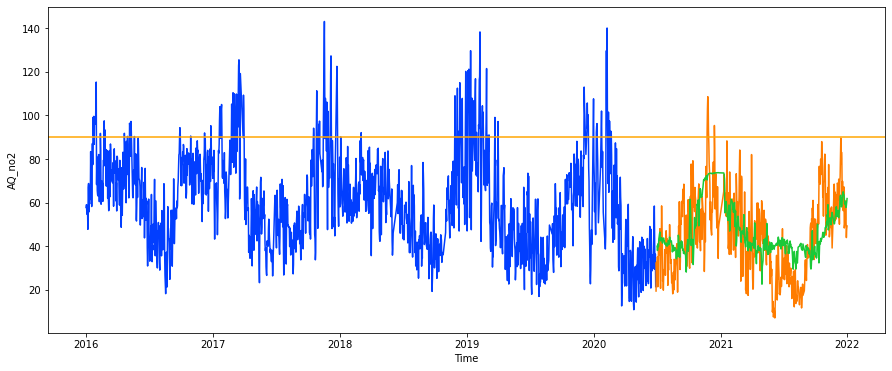

In [300]:
plt.figure(figsize=(15,6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_test.index, y=y_test)
sns.lineplot(x=X_test.index[3:], y=y_preds[:,0])
plt.axhline(90,color='orange');

In [301]:
# Check amount of days that have no2 in air quality > 90
performance = pd.DataFrame(y_test.iloc[3:])
performance['pred'] = y_preds
moderate_no2 = performance[performance['AQ_no2'] > 90].copy()
moderate_no2['pred_mod'] = (moderate_no2['pred'] > 90).astype(int)
moderate_no2.head()

,AQ_no2,pred,pred_mod
Time,,,
2020-11-23,92.45,70.357437,0
2020-11-24,103.00,72.071159,0
2020-11-25,108.60,72.523842,0
2020-11-26,107.70,72.993500,0
2020-11-27,92.83,73.204460,0


In [302]:
print(f"Predict NO2 > 90: {round(moderate_no2['pred_mod'].sum()/moderate_no2.shape[0]*100,2)}%")

Predict NO2 > 90: 0.0%


### LSTM model

In [308]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2. Compile
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

# 3. Fit
history = model.fit(train_sequences, validation_data=test_sequences,
                    epochs=100, callbacks=[es])
# 4. Predict
y_preds = model.predict(test_sequences)

Epoch 1/100
25/25 [==============================] - 4s 30ms/step - loss: 4115.8418 - val_loss: 2428.5681
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 4090.4829 - val_loss: 2392.7244
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 4032.6399 - val_loss: 2313.3281
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 3893.7080 - val_loss: 2125.3928
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 3533.5713 - val_loss: 1687.8835
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 2712.1926 - val_loss: 908.7028
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 1439.1946 - val_loss: 358.9822
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 488.7408 - val_loss: 490.6731
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 361.6109 - val_loss: 368.6154
Epoch 10/100
25/25 [==============================] - 0s 6ms

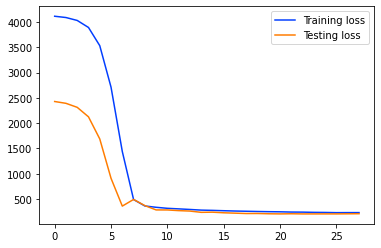

In [309]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Testing loss')
plt.legend();

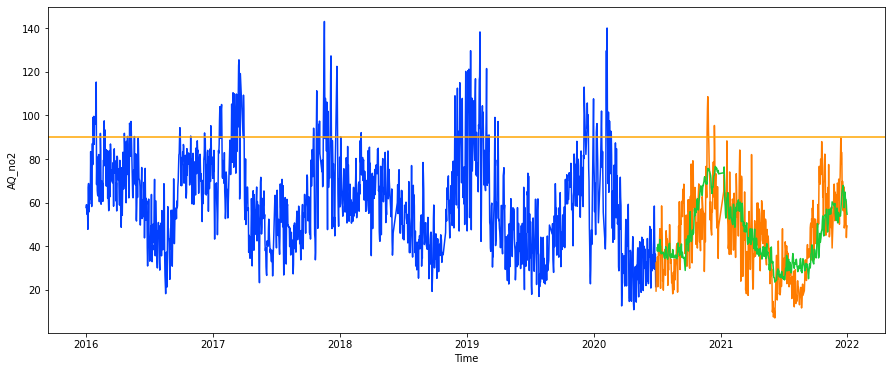

In [310]:
plt.figure(figsize=(15,6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_test.index, y=y_test)
sns.lineplot(x=X_test.index[3:], y=y_preds[:,0])
plt.axhline(90,color='orange');

In [311]:
# Check amount of days that have no2 in air quality > 90
performance = pd.DataFrame(y_test.iloc[3:])
performance['pred'] = y_preds
moderate_no2 = performance[performance['AQ_no2'] > 90].copy()
moderate_no2['pred_mod'] = (moderate_no2['pred'] > 90).astype(int)
moderate_no2.head()

,AQ_no2,pred,pred_mod
Time,,,
2020-11-23,92.45,69.088455,0
2020-11-24,103.00,73.668480,0
2020-11-25,108.60,75.397598,0
2020-11-26,107.70,75.723457,0
2020-11-27,92.83,74.775444,0


In [312]:
print(f"Predict NO2 > 90: {round(moderate_no2['pred_mod'].sum()/moderate_no2.shape[0]*100,2)}%")

Predict NO2 > 90: 0.0%


### Summary model for air quality: NO$_{2}$
The days have NO$_{2}$ quantity > 90 (Moderate air quality):
- RNN model can predict NO$_{2}$ > 90 equal to 0%.
- LSTM model can predict NO$_{2}$ > 90 equal to 0%.
- Both RNN and LSTM model can't predict the peak value of the data but both RNN and LSTM are really good in capturing the trend of the data.

## Model for predicting ammonia (NH$_{3}$) quantity of station 626

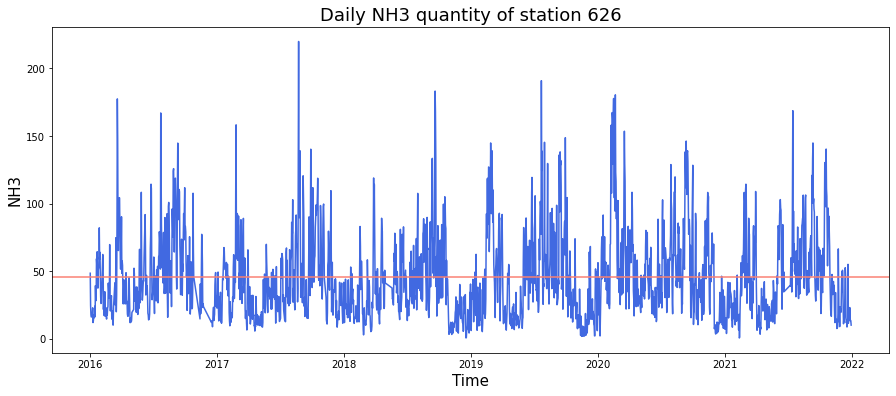

In [92]:
station_daily(station ='626',
              quality='nh3',
              label='NH3')

## Model for predicting PM$_{10}$ of station 661

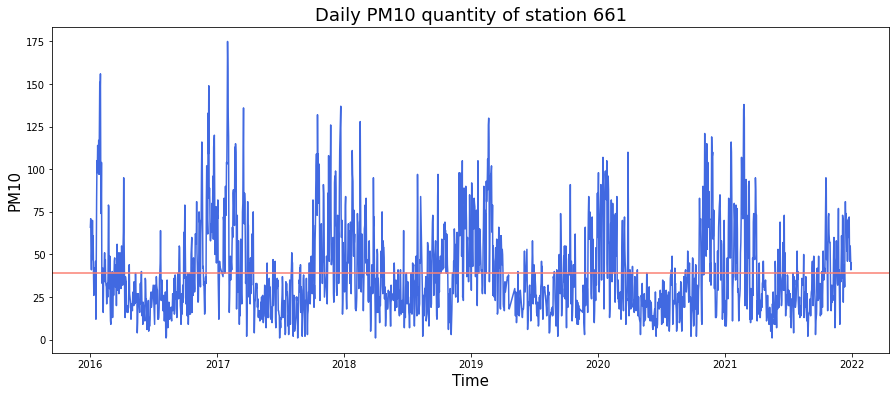

In [93]:
station_daily(station ='661',
              quality='pm10',
              label='PM10')

## Model for predicting PM$_{2.5}$ of station 1297

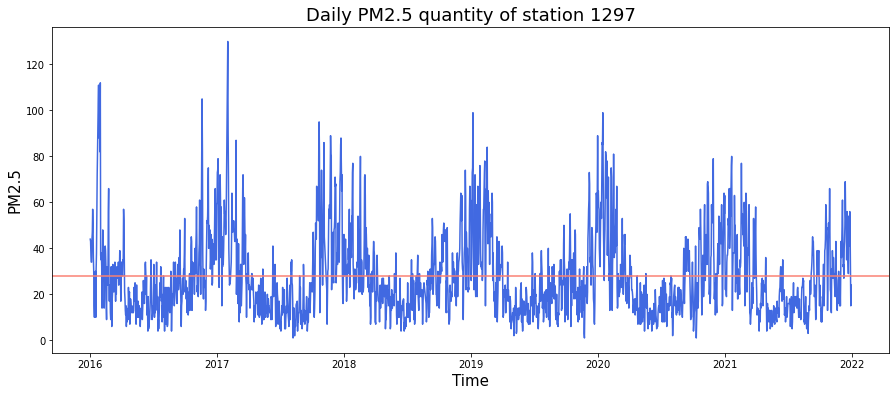

In [94]:
station_daily(station ='1297',
              quality='pm25',
              label='PM2.5')

## Model for predicting sulfur dioxide (SO$_{2}$) quantity of station STA.IT1509A

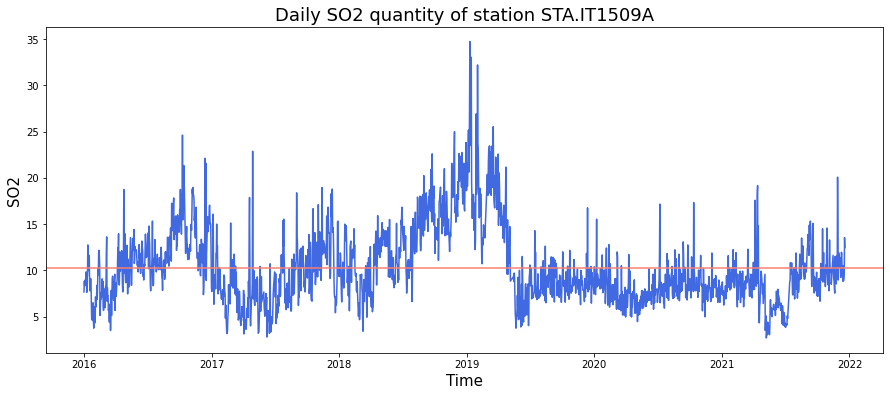

In [95]:
station_daily(station ='STA.IT1509A',
              quality='so2',
              label='SO2')

# Conclusion
---

# Recommendation
---